# Setting up a CNN for CIFAR-10

In this exercise, you are asked to set up a network with convolutional layers, pooling layers, and fully connected layers.


Training on CPU for this model can take 15-30 minutes for CIFAR-10 and up to 20-30 epochs.
GPU use for all students in IN 5400 is not yet ready, so unless you have access to own GPU, run on CPU with the default configutation below. 



In [33]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from utils.utility_functions import datasetFashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import torchvision.datasets
import torch.utils
import torch.utils.data.dataloader as dataloader

#from graphviz import Digraph
#matplotlib inline

## Load CIFAR-images

You might need to change the data directory if you are not on a linux computer at IFI. 



In [35]:
#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].
# Data
transform_train = transforms.Compose([
    # The crop is to normalize image size to 32x32
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    #The crop is to normalize image size to 32
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
CIFAR_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## TODO: if running on the GPU servers, no common data directory is yet available. Change root to ./data and download 
## temporally to your working area on the servers. 




train_dataset = torchvision.datasets.CIFAR10(root='cifar-10-batches-py', train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.CIFAR10(root='cifar-10-batches-py', train=False, download=True, transform=transform_val)
classes = CIFAR_classes




# DataLoader
batch_size=128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## Inspect some random images 



 ship horse plane  deer  frog  frog  bird   dog


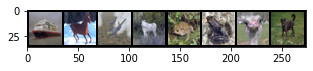

In [36]:
# get some random training images
nofdisplay = 8
train_loader_some = torch.utils.data.DataLoader(train_dataset, batch_size=nofdisplay, shuffle=True)
dataiter = iter(train_loader_some)
images, labels = dataiter.next()
images = images*0.2 + 0.5 #multiply by 0.2 and add 0.5 to approximately reverse the Normalize transform

# show images
def show(img):
    npimg = img.numpy()
    npimg = npimg.transpose((1,2,0))
    plt.imshow(npimg, interpolation='nearest')

# print(torchvision.utils.make_grid(images))
show(torchvision.utils.make_grid(images, padding=2, normalize=True, range=(0, 1)))

# print labels

print(' '.join('%5s' % CIFAR_classes[labels[j]] for j in range(nofdisplay)))


To keep track of important parameters, we use dictionary "config". You should experiment with different values for the batch size, learning rate and number of epochs trained.


Once your implementation work, you can try to improve the accuracy by changing the parameters, and the architecture.

When your code works with e.g. a couple of epochs, try using the GPU servers to do a longer traning and play with parameters. 

In [37]:
config = {
          'batch_size':128,
          'use_cuda': False,       #True=use Nvidia GPU | False use CPU
          'log_interval':20,      #How often to dislay (batch) loss during training
          'epochs': 5,           #Number of epochs
          'learningRate': 0.001,
          'momentum' : 0.9
         }

In [38]:
images.shape

torch.Size([8, 3, 32, 32])

Here we set up initialization and the basic network architecture.

Set up a basic network with 2 convolutional layers, each followed by max pool, uses Relu activation, and has two fully connected layers at the end. For RGB color images, the input layer has 3 band, and for gray level images it only has 1 input band.

Suggestions: Conv-layer 1 can have 6 5x5-filters, ReLU, followed by max pool with size 2.

Conv-layer 2 can initially have 16 5x5-filters, ReLU, followed by maxpool with size 2.

Then reshape the input to match a linear layer. Use initially 3 fully conntectedlayers, with output size 120, 84, and 10.

The number of output nodes in the output layer must correspond to the number of classes, in our case 10.

The resulting network will resemble LeNET, the first pioneering convolutional network, but with ReLU. 

Hint: see the solution to the exercise in week 5. Use nn.Conv2D, nn. MaxPool2d, and nn.Linear


In [39]:
class Model(nn.Module):
     
    def __init__(self):
        super(Model, self).__init__()
        #Start with the solution to the first pytorch exercise. 
        
        self.conv = nn.Sequential(
                        nn.Conv2d(3, 6, (5,5)), # [128, 6, 28, 28]
                        nn.ReLU(),
                        nn.MaxPool2d((2,2), 2), # [128, 6, 14, 14]
                        nn.ReLU(),
                        nn.Conv2d(6, 16, (5,5)), # [128, 16, 10, 10]
                        nn.ReLU(),
                        nn.MaxPool2d((2,2), 2), # [128, 16, 5, 5]
                        nn.ReLU()
        )
        
        self.lin = nn.Sequential(
                        nn.Linear(16 * 5 * 5, 120),
                        nn.ReLU(),
                        nn.Linear(120, 84),
                        nn.ReLU(),
                        nn.Linear(84, 10)
        )
        
    def forward(self, x):
        
        # Let x propage from input to output.
        # Take care by reshaping using x.view when flattening the data from convolutional to fully connected layers.
        
        x = self.conv(x)
        x = x.view((-1, x.shape[1] * x.shape[2] * x.shape[3]))
        x = self.lin(x)
        
        return x


In [40]:
# Creat an instance of Model
model = Model()
if config['use_cuda'] == True:
    model.to('cuda')

## Step 3: Define optimizer and loss function

Instantiate an optimizer, e.g. stochastic gradient descent, from the "torch.optim" module (https://pytorch.org/docs/stable/optim.html) with your model. Remember that we have defined "learning rate" inside the config-dictionary.



In [41]:
# Create an instance of "torch.optim.SGD"
import torch.optim as optim

#ToDo
# Try with and without momentum, and with Adam
#optimizer = optim.SGD(model.parameters(), lr=config['learningRate'])
optimizer = optim.Adam(model.parameters(), lr=config['learningRate'])


Here we want to define the loss function (often called criterion). As we are dealing with a classification problem, you should use the softmax cross entropy loss.

Hint, have a look here: (https://pytorch.org/docs/stable/nn.html#torch-nn-functional)

In [42]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    #ToDo
    import torch.nn.functional as F
    loss = F.cross_entropy(input=prediction, target=labels)
   
    
    return loss

## Step 4: Set up the training process and train the model

You have all the building blocks needed to set up the training process. You will implement the function "run_epoch" which shall loop though a dataset and train the model.

In [43]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not. 
        config      (dict): Configuration parameters

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches. 
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """
    
    if is_training==True: 
        model.train()
    else:
        model.eval()

    total_loss        = 0 
    correct          = 0 
    confusion_matrix = np.zeros(shape=(10,10))
    labels_list      = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, data_batch in enumerate(data_loader):
        if config['use_cuda'] == True:
            images = data_batch[0].to('cuda') # send data to GPU
            labels = data_batch[1].to('cuda') # send data to GPU
        else:
            images = data_batch[0]
            labels = data_batch[1]

        if not is_training:
            with torch.no_grad():
                # ToDo: Forward
                prediction = model.forward(images)
                
                
                # ToDo: Compute loss
                # Note: It can be beneficial to detach "total_loss" from the graph, consider convert "total_loss" to numpy.
                loss = loss_fn(prediction, labels)
                total_loss += loss.item()
            
        elif is_training: 
            
            
            # ToDo: Forward
            prediction = model.forward(images)
          
            # ToDo: Compute loss
            # Note: It can be beneficial to detach "total_loss" from the graph, consider convert "total_loss" to numpy.
            loss = loss_fn(prediction, labels)
            total_loss += loss.item()

            # ToDo: take a gradient update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        # Compute the correct classification
        predicted_label  = prediction.max(1, keepdim=True)[1][:,0]
        correct          += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(labels.cpu().numpy(), predicted_label.cpu().numpy(), labels_list)

        # Print statistics
        batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print(f'Epoch={epoch} | {batch_idx/len(data_loader)*100:.2f}% | loss = {loss/batchSize:.5f}')

    loss_avg         = total_loss / len(data_loader)
    accuracy         = correct / len(data_loader.dataset)
    if  is_training:
        #print(correct)
        #print(len(data_loader.dataset))
        print('Current training accuracy:', accuracy)
    if not is_training:
    #    print(correct)
    #    print(len(data_loader.dataset))
        print('Current validation accuracy',accuracy)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix


In [44]:
# training the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])
val_confusion_matrix   = np.zeros(shape=(10,10,config['epochs']))
train_confusion_matrix = np.zeros(shape=(10,10,config['epochs']))
init_lr = config['learningRate']
for epoch in range(config['epochs']):
    
    
    
    train_loss[epoch], train_acc[epoch], train_confusion_matrix[:,:,epoch] = \
                               run_epoch(model, epoch, train_loader, optimizer, is_training=True, config=config)

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:,:,epoch]     = \
                               run_epoch(model, epoch, val_loader, optimizer, is_training=False, config=config)
    
    
    

Epoch=0 | 0.00% | loss = 0.01799
Epoch=0 | 5.12% | loss = 0.01618
Epoch=0 | 10.23% | loss = 0.01481
Epoch=0 | 15.35% | loss = 0.01460
Epoch=0 | 20.46% | loss = 0.01323
Epoch=0 | 25.58% | loss = 0.01456
Epoch=0 | 30.69% | loss = 0.01236
Epoch=0 | 35.81% | loss = 0.01228
Epoch=0 | 40.92% | loss = 0.01275
Epoch=0 | 46.04% | loss = 0.01233
Epoch=0 | 51.15% | loss = 0.01285
Epoch=0 | 56.27% | loss = 0.01164
Epoch=0 | 61.38% | loss = 0.01190
Epoch=0 | 66.50% | loss = 0.01133
Epoch=0 | 71.61% | loss = 0.01121
Epoch=0 | 76.73% | loss = 0.01308
Epoch=0 | 81.84% | loss = 0.01064
Epoch=0 | 86.96% | loss = 0.01140
Epoch=0 | 92.07% | loss = 0.01155
Epoch=0 | 97.19% | loss = 0.01102
Current training accuracy: 0.39724
Epoch=0 | 0.00% | loss = 0.01317
Epoch=0 | 25.32% | loss = 0.01472
Epoch=0 | 50.63% | loss = 0.01391
Epoch=0 | 75.95% | loss = 0.01157
Current validation accuracy 0.3846
Epoch=1 | 0.00% | loss = 0.01109
Epoch=1 | 5.12% | loss = 0.01199
Epoch=1 | 10.23% | loss = 0.01047
Epoch=1 | 15.35% 

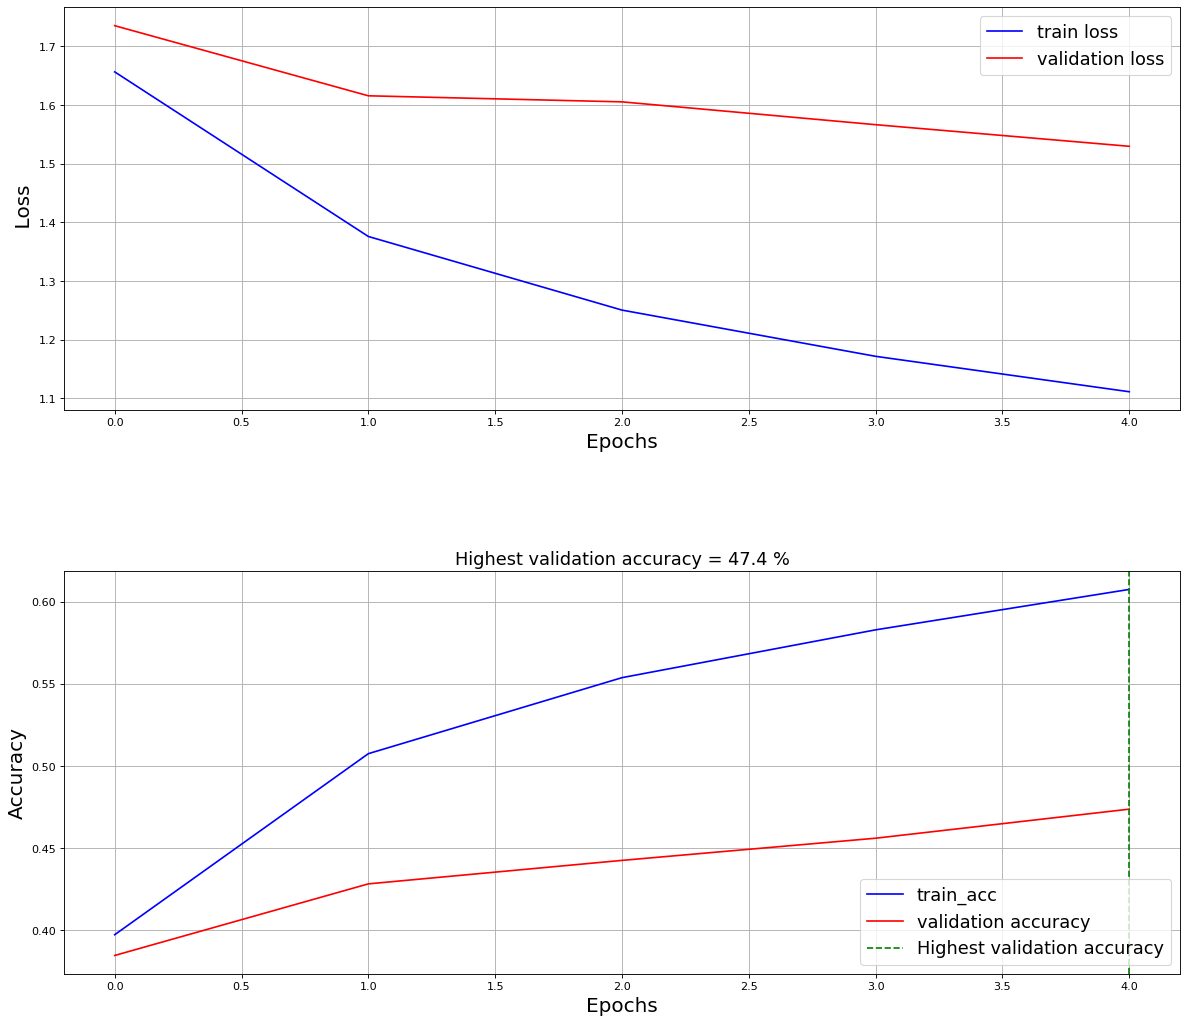

In [45]:
# Plot the training accuracy and the training loss
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel(' Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train_acc')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)



plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

In [46]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:,:,ind]
for ii in range(len(classes)):
    acc = val_confusion_matrix[ii,ii,ind] / np.sum(val_confusion_matrix[ii,:,ind])
    print(f'Accuracy of {str(classes[ii]).ljust(15)}: {acc*100:.01f}%')

Accuracy of plane          : 31.5%
Accuracy of car            : 71.5%
Accuracy of bird           : 27.6%
Accuracy of cat            : 36.4%
Accuracy of deer           : 24.0%
Accuracy of dog            : 43.9%
Accuracy of frog           : 59.9%
Accuracy of horse          : 59.4%
Accuracy of ship           : 59.6%
Accuracy of truck          : 59.9%


## How to improve

Now we have trained a basic network. Try using different learning rates, e.g. from 0.1, 0.01, 0.001 and smaller.

How does the learning loss function and the accuracy for the traning set look? 

What does it mean when the accuracy of the traning data set is much lower than on the traning data set?


Note that we have no regularization, so the generalization ability of the network is likely to be limited. 


## Further work

Try to change the architecture, optimizer and the learning rate. Add more layers and more filters. Add batchnorm.  Does the performance improve?

Changed the optimizer from SG to Adam and the accuracy became much better. 